In [1]:
#%reset -f
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask as da
import glob
import time
from datetime import datetime, timedelta as delta
from matplotlib import path
from matplotlib.collections import PolyCollection #for plots polygons as rasters
#for animation
import matplotlib.animation as animation
from copy import deepcopy
import matplotlib as mpl
import time
#import tqdm 
from tqdm import tqdm #to see progressbar for loops
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find neighbor)
%matplotlib inline
# to see the plot labels when using jupyter-lab dark mode
from matplotlib import style
#style.use('classic') #like matlab style (gray background, but white when saving figures)
#style.use('ggplot')
style.use('default') #the above styles problems with PolyCollection 
#print(style.available) #to see the styles 
import pickle #to save data as binary file .pkl
from windrose import WindroseAxes
import seaborn as sns #for heat maps of correlation and RMSD
from itertools import product #to make all possible permutations including repeated values
#
from scipy.interpolate import griddata #interpolation in space for non-uniform grids
from scipy.interpolate import interp1d #1d interp

#for projections
from pyproj import Proj, transform, Transformer

In [2]:
#dirs
home_dir="/export/lv4/user/jfajardourbina/"
dir_wind=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
dir_dws_bound=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
file_grid=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
dir_vel=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/velocity/" #vel data
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
#files
file_dws_bound0="dws_boundaries_contour0.nc"
file_vel="RE.DWS200m.uvz.20090301.nc" #any vel file
file_wind="UERRA.2009.nc4" #any wind file
#
dir_post_proc_data=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/post_proc_data/"
dir_interp_wind="wind"

In [3]:
# #fixing wind data interpolated (it was saved in projected coordinates)---
# #transform to model coordinates
# ang2=17*np.pi/180
# files_interp_wind=sorted(glob.glob(f'{dir_post_proc_data}{dir_interp_wind}/*.nc',recursive=True))
# #all the years take 1.5h
# for file_wind in tqdm(files_interp_wind):

#     year=int(str(file_wind)[-55:-51])
#     print(year)

#     dsw=xr.open_dataset(file_wind).load();dsw.close() #wind interp
#     #os.remove(path=file_wind)
#     u10t=dsw.u10; v10t=dsw.v10
#     u10= np.cos(ang2)*u10t + np.sin(ang2)*v10t
#     v10= -np.sin(ang2)*u10t + np.cos(ang2)*v10t
#     dsw["u10"].values=u10.values; dsw["v10"].values=v10.values; 
#     dsw.attrs["temporal_info"]=f"Wind components were linearly interpolated to 566s (factor of M2={m2}s), and then averaged during the M2 interval of the net displacement."
#     dsw.attrs["spatial_info"]="1) Wind components were interpolated with cubic-spline in EPSG:28992 projection. 2) Then projected to GETM model xc and yc local coordinates. 3) Finally, nearest-interpolated to xc-yc particle grid."
#     filew=f"{dir_post_proc_data}wind_new/{year}_avg_wind_during_1M2_and_interpolated_to_particle_grid.nc"
#     dsw.to_netcdf(filew)

In [4]:
#open interp files for wind
files_interp_wind=sorted(glob.glob(f'{dir_post_proc_data}{dir_interp_wind}/*.nc',recursive=True))
#concat all the files
dswi=xr.open_mfdataset(files_interp_wind,concat_dim="time",parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets

In [5]:
#open topo file
dsto=xr.open_dataset(file_grid+"DWS200m.2012.v03.nc") 
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)

#open DWS contours
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0

#open any vel data
dsv=xr.open_dataset(dir_vel+file_vel)
xcv=dsv.xc; ycv=dsv.yc; hv=dsv.bathymetry.load()
xcv0=xcv.min().values/1e3; ycv0=ycv.min().values/1e3
dsv.close()

#open any wind data
dsw=xr.open_dataset(dir_wind+file_wind) #winds
dsw.close()


#index from the model topo grid units from which the velocity y-axis start and finish
#the model of the simulation is shorter in the y-axis than the full topo domain
iy0=np.nonzero(dsto.yc.values==dsv.yc[0].values)[0][0]
#print(iy0,dsto.yc.values[iy0],dsv.yc.values[0])
iy1=np.nonzero(dsto.yc.values==dsv.yc[-1].values)[0][0]
#print(iy1,dsto.yc.values[iy1],dsv.yc.values[-1])

#create mask for islands
h=dsto.bathymetry; mask=h.where(np.isnan(h),1); mask=mask.where(np.isfinite(h),0)

#define the transformations------
#1)
#from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
#2)
#from epgs:4326(LatLon with WGS84) to epgs:28992(DWS) 
inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)
#inproj_old=Proj("EPSG:28992") #old method (has errors 10-20m when contrast with the rotated coords)

#lon,lat to 28992(DWS)-projection--------------------

#bathymetry--------
xct=dsto.lonc.values;  yct=dsto.latc.values #lon,lat units
xctp,yctp,z = inproj.transform(xct,yct,xct*0.)
#[xctp,yctp] = inproj_old(xct,yct) #old method
xctp=(xctp)/1e3; yctp=(yctp)/1e3 
#first projected point to correct the coordinates of model local meter units
xctp0=xctp[0,0]; yctp0=yctp[0,0]

#wind original 2h-data--------
#use the full domain---
#usually problems when using local projection for big domains, but for our case no problems
xcw,ycw=np.meshgrid(dsw.lon.values,dsw.lat.values)
xcwp,ycwp,z = inproj.transform(xcw,ycw,xcw*0.)
xcwp=xcwp/1e3; ycwp=ycwp/1e3
#xcw=(xcw-xcw[0,0])/1e3; ycw=(ycw-ycw[0,0])/1e3
#use a short domain around DWS---
xcw2,ycw2=np.meshgrid(dsw.lon.sel(lon=slice(4,6.5)).values,dsw.lat.sel(lat=slice(52.5,53.75)).values)
xcwp2,ycwp2,z = inproj.transform(xcw2,ycw2,xcw2*0.)
xcwp2=(xcwp2)/1e3; ycwp2=(ycwp2)/1e3


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#matrix rotation -17degrees-----
ang=-17*np.pi/180
angs=np.ones((2,2))
angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)

#bathymetry----
#original topo points in meter
xct2,yct2=np.meshgrid(dsto.xc.values,dsto.yc.values)
xy=np.array([xct2.flatten(),yct2.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
xyp0=xyp[0,:] #the first point in the bathy data in local meter units=0,0
#correct model units:
#1)substact the first model local point of the topo file, but give tha same as xyp0=[0,0]
#2)use the first projected point of the case (lon,lat model units to meter)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dsto.yc.values),len(dsto.xc.values),2))
xctp2=xyp[...,0]; yctp2=xyp[...,1] #km
#
#contrast projections (lon,lat model units to meter) with rotated case
#around 0 meter diff with new method
#10 meter difference in average and maximum of 20 with old method
a=xctp-xctp2; b=yctp-yctp2
print(np.abs(a).max()*1e3, np.abs(b).max()*1e3, np.abs(a).mean()*1e3, np.abs(b).mean()*1e3) 

#contour0 of DWS------
#rotate
bdr_dws0p=np.matmul(angs,bdr_dws0.T).T/1e3
#correct model units:
#1)substact the first model local point of the topo file, but give tha same as xyp0=[0,0]
#2)use the first projected point of the case (lon,lat model units to meter)
bdr_dws0p=bdr_dws0p-xyp0 
bdr_dws0p[:,0]=bdr_dws0p[:,0]+xctp0; bdr_dws0p[:,1]=bdr_dws0p[:,1]+yctp0
#
#get coordinates in lon-lat units (WGS84 ) 
bdr_dws0_lon, bdr_dws0_lat, z = proj.transform(bdr_dws0p[:,0]*1e3,bdr_dws0p[:,1]*1e3, bdr_dws0p[:,1]*0.)

#wind in particle grid------
xcwi,ycwi=np.meshgrid(dswi.x.values,dswi.y.values)
xy=np.array([xcwi.flatten(),ycwi.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
#correct model units:
#1)substact the first model local point of the topo file, but give tha same as xyp0=[0,0]
#2)use the first projected point of the case (lon,lat model units to meter)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dswi.y.values),len(dswi.x.values),2))
xcwip=xyp[...,0]; ycwip=xyp[...,1] #km

#mid point of texel transect---
xymid=np.expand_dims(dsb0.tr_dws_marsdiep[len(dsb0.tr_dws_marsdiep)//2].values,1).T
#find nearest point for wind--------
ixt=np.argmin(abs(dswi.x.values-xymid[0,0])) 
iyt=np.argmin(abs(dswi.y.values-xymid[0,1]))
xyt=np.array([[dswi.x.values[ixt]],[dswi.y.values[iyt]]]).T
#project
xytp=np.matmul(angs,xyt.T).T/1e3 #rotate
#correct model units
xytp=xytp-xyp0; xytp[:,0]=xytp[:,0]+xctp0; xytp[:,1]=xytp[:,1]+yctp0
#to lon-lat
lont, latt, z = proj.transform(xytp[:,0]*1e3,xytp[:,1]*1e3, xytp[:,1]*0.)

#mid point of vlie-------
xymid=np.expand_dims(dsb0.tr_dws_vlie[len(dsb0.tr_dws_vlie)//2].values,1).T
#find nearest point for wind--------
ixv=np.argmin(abs(dswi.x.values-xymid[0,0])) 
iyv=np.argmin(abs(dswi.y.values-xymid[0,1]))
xyv=np.array([[dswi.x.values[ixv]],[dswi.y.values[iyv]]]).T
#project
xyvp=np.matmul(angs,xyv.T).T/1e3 #rotate
#correct model units
xyvp=xyvp-xyp0; xyvp[:,0]=xyvp[:,0]+xctp0; xyvp[:,1]=xyvp[:,1]+yctp0
#to lon-lat
lonv, latv, z = proj.transform(xyvp[:,0]*1e3,xyvp[:,1]*1e3, xyvp[:,1]*0.)

#eastern DWS (low mean)-------
#latedw=53.4; lonedw=5.8
#to projection
#xedwp,yedwp,z = inproj.transform(lonedw,latedw,0.)
#xedwp=xedwp/1e3; yedwp=yedwp/1e3
#to model units

0.026940217722426496 0.3400088997977946 0.009365292291273685 0.1443332403121348


In [6]:
def vel_from_local_coords_to_projection(u10,v10,ang=-17*np.pi/180):
    return np.cos(ang)*u10 + np.sin(ang)*v10, -np.sin(ang)*u10 + np.cos(ang)*v10

2012-11-25T05:38:00.000000000


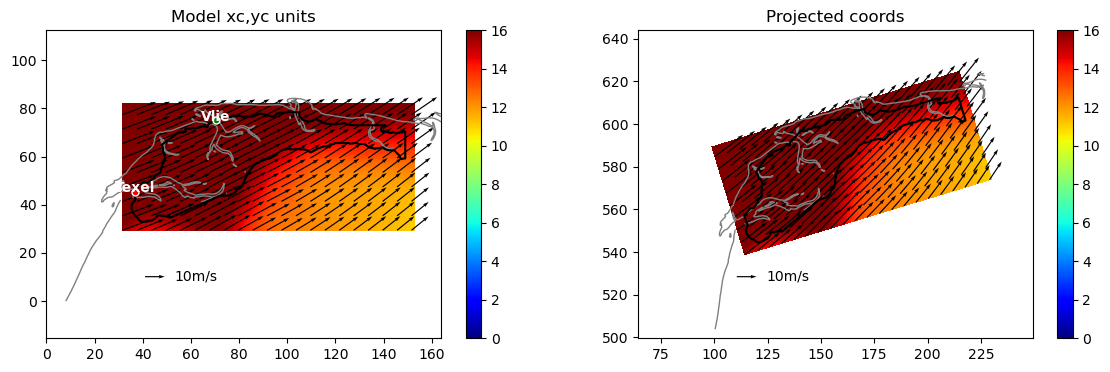

In [7]:
#checking the wind for a particular time---

fig,ax= plt.subplots(1,2,figsize=(14,4))

iyy=15;ixx=15
units='width';width=0.003;scale=200
#it=100
#it=np.nonzero(dswi.time.values==np.datetime64("2009-11-25T15:19:02"))[0][0] #SW
#it=np.nonzero(dswi.time.values==np.datetime64("2012-11-24T17:12:46"))[0][0] #SE
#during the next m2 interval a strong (SW), that only last in total: 2 M2 intervals
it=np.nonzero(dswi.time.values==np.datetime64("2012-11-24T17:12:46"))[0][0]+1 #strong SW
#velocity in local coords---
u10t=dswi.u10.isel(time=it); v10t=dswi.v10.isel(time=it)
vel0=(u10t**2+v10t**2)**.5
#velocity in projected coords---
#explicity (this is better because keep the xarray structure)
u10tp,v10tp=vel_from_local_coords_to_projection(u10t,v10t)
#using matrix
#uv10tp=np.expand_dims(np.stack((u10t,v10t),axis=-1),-1)
#uv10tp=np.squeeze(np.matmul(angs,uv10tp))
#u10tp,v10tp=uv10tp[...,0],uv10tp[...,1]; del uv10tp

#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[0].pcolormesh(dswi.x/1e3,dswi.y/1e3,vel0,vmin=0,vmax=16,shading='auto',cmap='jet') #wind correct orientation
plt.colorbar(aa,ax=ax[0])
ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax[0].plot(dswi.x.values[ixt]/1e3,dswi.y.values[iyt]/1e3,'or',markersize=5,markeredgecolor='w') 
ax[0].text(dswi.x.values[ixt]/1e3,dswi.y.values[iyt]/1e3,'Texel',color='snow',weight='bold',ha='center') 
ax[0].plot(dswi.x.values[ixv]/1e3,dswi.y.values[iyv]/1e3,'og',markersize=5,markeredgecolor='w') 
ax[0].text(dswi.x.values[ixv]/1e3,dswi.y.values[iyv]/1e3,'Vlie',color='snow',weight='bold',ha='center') 
Q = ax[0].quiver(xcwi[::iyy,::ixx]/1e3,ycwi[::iyy,::ixx]/1e3,u10t[::iyy,::ixx],v10t[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax[0].quiverkey(Q, .3, .2, 10, '10m/s', labelpos='E',coordinates='axes')
ax[0].axis('equal')#;ax[0].axis([30,150,30,80])
ax[0].set_title('Model xc,yc units');
#
#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[1].pcolormesh(xcwip,ycwip,vel0,vmin=0,vmax=16,shading='auto',cmap='jet') #wind correct orientation
plt.colorbar(aa,ax=ax[1])
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
Q = ax[1].quiver(xcwip[::iyy,::ixx],ycwip[::iyy,::ixx],u10tp[::iyy,::ixx],v10tp[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax[1].quiverkey(Q, .3, .2, 10, '10m/s', labelpos='E',coordinates='axes')
ax[1].axis('equal');#ax[1].axis([30,150,30,80])
#plt.axis([80,250,530,630])
ax[1].set_title('Projected coords');

print(dswi.time.isel(time=it).values)

In [23]:
%%time
#check: https://www.ndbc.noaa.gov/wndav.shtml

#mean wind speed and direction using vector definition----
#like NOA vectorial
u10mean,v10mean=da.compute(dswi.u10.mean(dim='time'),dswi.v10.mean(dim='time'))
ws_mean_vector=(u10mean**2+v10mean**2)**.5
wd_mean_vector=np.arctan2(v10mean,u10mean)
#u10mean=ws_mean_vector*np.cos(wd_mean_vector)
#v10mean=ws_mean_vector*np.sin(wd_mean_vector)

#scalar definition----
ws_mean_scalar=((dswi.u10**2+dswi.v10**2)**.5).mean(dim='time').load() #Like NOA
#this is not like NOA, just use the angles from above to get components scaling with speed
#this is similar to the definition of a rotary angle
u10mean_scalar_from_vector=ws_mean_scalar*np.cos(wd_mean_vector)
v10mean_scalar_from_vector=ws_mean_scalar*np.sin(wd_mean_vector)

CPU times: user 9.66 s, sys: 12.3 s, total: 22 s
Wall time: 14.6 s


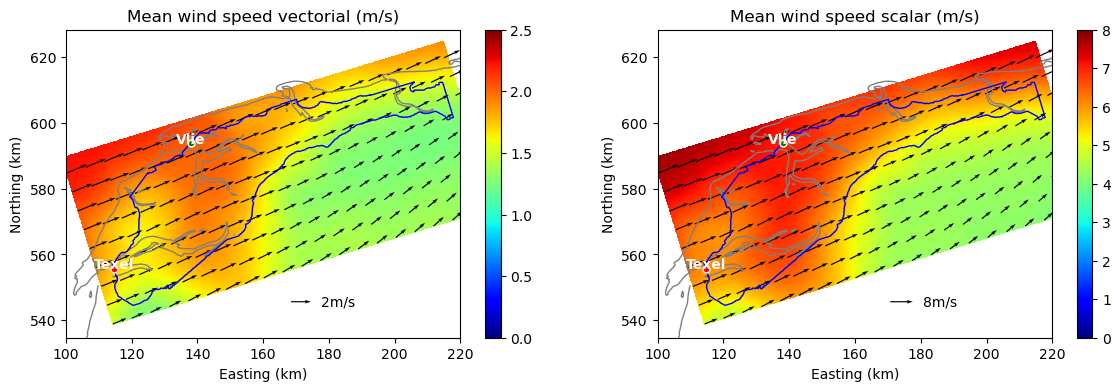

In [30]:
fig,ax= plt.subplots(1,2,figsize=(14,4))
#
aa=ax[0].pcolormesh(xcwip,ycwip,ws_mean_vector,vmin=0,vmax=2.5,shading='auto',cmap='jet')#wind-energy lon-lat
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'b',lw=1) #DWS limits
ax[0].axis('equal');ax[0].axis([100,220,543,620])
ax[0].set_xlabel('Easting (km)');ax[0].set_ylabel('Northing (km)');
ax[0].set_title('Mean wind speed vectorial (m/s)');
plt.colorbar(aa,ax=ax[0])
#
#vel_from_local_coords_to_projection
u10meanp,v10meanp=vel_from_local_coords_to_projection(u10mean,v10mean)
iyy=15;ixx=15
Q = ax[0].quiver(xcwip[::iyy,::ixx],ycwip[::iyy,::ixx],u10meanp[::iyy,::ixx],v10meanp[::iyy,::ixx],units='width',width=0.003,color='k')
qk = ax[0].quiverkey(Q, 0.3, 0.2, 2, '2m/s', labelpos='E',coordinates='figure')
#
ax[0].plot(xytp[0,0],xytp[0,1],'or',markersize=5,markeredgecolor='w') 
ax[0].text(xytp[0,0],xytp[0,1],'Texel',color='snow',weight='bold',ha='center') 
ax[0].plot(xyvp[0,0],xyvp[0,1],'og',markersize=5,markeredgecolor='w') 
ax[0].text(xyvp[0,0],xyvp[0,1],'Vlie',color='snow',weight='bold',ha='center') 
#ax[0].plot(xedwp[0,0],yedwp[0,1],'or',markersize=5,markeredgecolor='w') 
#ax[0].text(xedwp[0,0],yedwp[0,1],'EDWS',color='snow',weight='bold',ha='center') 
#
aa=ax[1].pcolormesh(xcwip,ycwip,ws_mean_scalar,vmin=0,vmax=8,shading='auto',cmap='jet')#wind-energy lon-lat
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'b',lw=1) #DWS limits
ax[1].axis('equal');ax[1].axis([100,220,543,620])
ax[1].set_xlabel('Easting (km)');ax[1].set_ylabel('Northing (km)');
ax[1].set_title('Mean wind speed scalar (m/s)');
plt.colorbar(aa,ax=ax[1])
#
#vel_from_local_coords_to_projection
u10mean_scalar_from_vectorp,v10mean_scalar_from_vectorp=vel_from_local_coords_to_projection(u10mean_scalar_from_vector,v10mean_scalar_from_vector)
Q = ax[1].quiver(xcwip[::iyy,::ixx],ycwip[::iyy,::ixx],u10mean_scalar_from_vectorp[::iyy,::ixx],v10mean_scalar_from_vectorp[::iyy,::ixx],units='width',width=0.003,color='k')
qk = ax[1].quiverkey(Q, 0.73, 0.2, 8, '8m/s', labelpos='E',coordinates='figure')
#
ax[1].plot(xytp[0,0],xytp[0,1],'or',markersize=5,markeredgecolor='w') 
ax[1].text(xytp[0,0],xytp[0,1],'Texel',color='snow',weight='bold',ha='center') 
ax[1].plot(xyvp[0,0],xyvp[0,1],'og',markersize=5,markeredgecolor='w') 
ax[1].text(xyvp[0,0],xyvp[0,1],'Vlie',color='snow',weight='bold',ha='center') ;

In [57]:
def get_autocorr(ws_xr,tw):
    
    dtw=np.diff(tw) / np.timedelta64(1,'s')
    dtw=dtw[0]/3600 #=1h
    #
    #num time steps for the month with less data (February)
    #we will set the length of the lag correlation of all the months to this value
    ntcor=int(24/dtw*28) 
    #
    #compute lag correlation for each month
    
    #first group the years, then the months
    autocorr=[]
    for label0, x0 in ws_xr.groupby('time.year'):
        for label1, x1 in x0.groupby('time.month'):
            #print(label1)
            val=np.correlate(x1-x1.mean(),x1-x1.mean(),mode='full')[-len(x1.time):] #pad with zeros when lag time series
            val/=val[0] #normalized autocorrelation
            autocorr.append(val[:ntcor])
    autocorr=np.array(autocorr).T #(lag,months)
    tlag=np.arange(0,autocorr.shape[0]*dtw,dtw)/24 #days
    #months=np.arange(1,13)

    #np.correlate does below:
    # avg=x.mean().values; var=np.sum((x.values-avg)**2)
    # val=x-avg; val=val.values
    # cor=[]
    # for lag in range(autocorr.shape[1]):
    #     if lag==0: cor.append(1)
    #     else: cor.append(np.sum(val[:-lag]*val[lag:])/var)
    # cor=np.array(cor)
    # #both are the same
    # plt.plot(tlag,cor,'b')
    # plt.plot(tlag,autocorr[-1,:],'r')
    
    return tlag,autocorr

In [58]:
tw=dswi.time.values

In [59]:
#texel---
ws_mean_scalar_tex=((dswi.u10.isel(x=ixt,y=iyt)**2+dswi.v10.isel(x=ixt,y=iyt)**2)**.5).load()
tlag,autocorr_tex=get_autocorr(ws_mean_scalar_tex,tw) 
yearini="1980"; yearend="2016"
tcorr_tex=np.arange(yearini,yearend,1,dtype='datetime64[M]')[:-2] #skip nov and dec of 2015

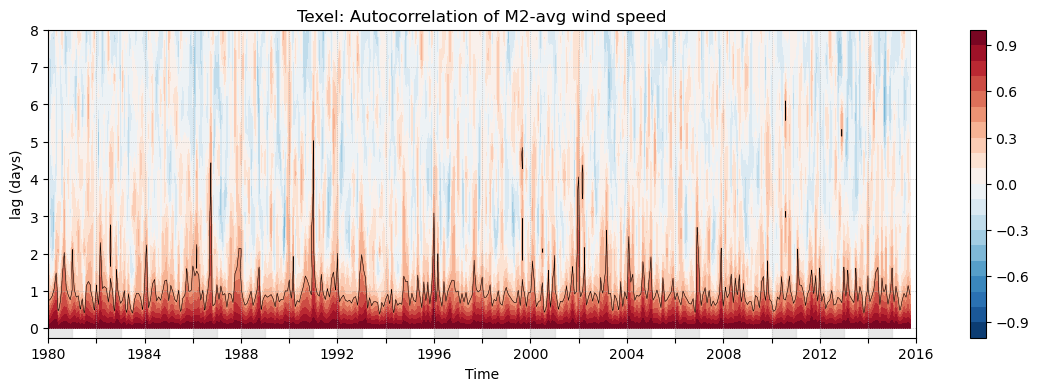

In [93]:
fig,ax=plt.subplots(1,1,figsize=(14,4))
#
#ticks for time 
xticks_lab=np.arange(int(str(tw[0])[:4]),int(str(tw[-1])[:4])+2,2)
xticks=[np.datetime64(str(i)+'-01-01') for i in xticks_lab]
tt=np.arange(np.datetime64("1980"),np.datetime64("2018"),2)
tt2=np.arange(np.datetime64("1981"),np.datetime64("2017"),2)
for i in range(len(tt)-1): ax.axvspan(tt[i],tt2[i],alpha=0.5,color='lightgrey',zorder=0) 
ax.set_xlim([xticks[0],xticks[-1]])
ax.set_xticks(xticks); ax.set_xticklabels(xticks_lab);
for label in ax.get_xticklabels()[1::2]: label.set_visible(False) #hide every 2 tick label
ax.tick_params(direction="out");
#
#time_ticklabels=['J','F','M','A','M','J','J','A','S','O','N','D']
cb=ax.contourf(tcorr_tex,tlag,autocorr_tex,levels=np.arange(-1,1.1,.1),cmap='RdBu_r',zorder=1);plt.colorbar(cb,ax=ax)
ax.contour(tcorr_tex,tlag,autocorr_tex,[.4],colors='k',linestyles='-',linewidths=.4)
ax.set_ylim(-.25,8);ax.set_ylabel('lag (days)');ax.set_xlabel("Time");ax.set_title(f"Texel: Autocorrelation of M2-avg wind speed");
ax.grid(lw=.5,ls=':')
#

In [87]:
#vlie---
ws_mean_scalar_vlie=((dswi.u10.isel(x=ixv,y=iyv)**2+dswi.v10.isel(x=ixv,y=iyv)**2)**.5).load()
tlag,autocorr_vlie=get_autocorr(ws_mean_scalar_vlie,tw) 
yearini="1980"; yearend="2016"
tcorr_vlie=np.arange(yearini,yearend,1,dtype='datetime64[M]')[:-2] #skip nov and dec of 2015

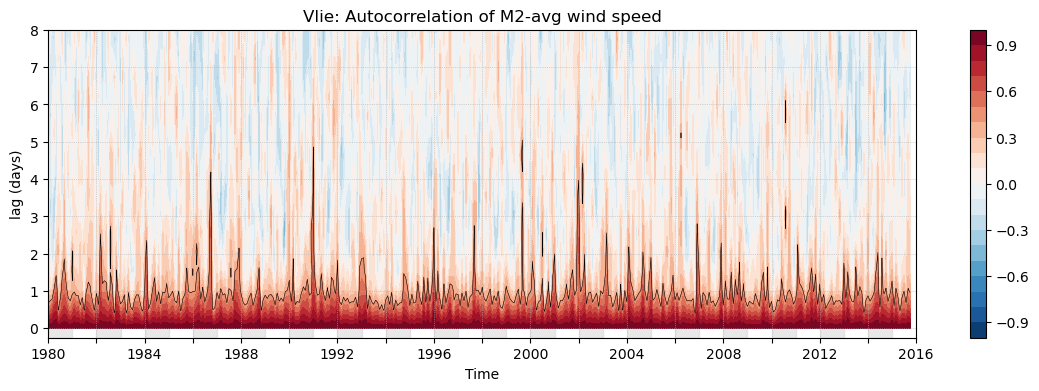

In [94]:
fig,ax=plt.subplots(1,1,figsize=(14,4))
#
#ticks for time 
xticks_lab=np.arange(int(str(tw[0])[:4]),int(str(tw[-1])[:4])+2,2)
xticks=[np.datetime64(str(i)+'-01-01') for i in xticks_lab]
tt=np.arange(np.datetime64("1980"),np.datetime64("2018"),2)
tt2=np.arange(np.datetime64("1981"),np.datetime64("2017"),2)
for i in range(len(tt)-1): ax.axvspan(tt[i],tt2[i],alpha=0.5,color='lightgrey',zorder=0) 
ax.set_xlim([xticks[0],xticks[-1]])
ax.set_xticks(xticks); ax.set_xticklabels(xticks_lab);
for label in ax.get_xticklabels()[1::2]: label.set_visible(False) #hide every 2 tick label
ax.tick_params(direction="out");
#
#time_ticklabels=['J','F','M','A','M','J','J','A','S','O','N','D']
cb=ax.contourf(tcorr_vlie,tlag,autocorr_vlie,levels=np.arange(-1,1.1,.1),cmap='RdBu_r',zorder=1);plt.colorbar(cb,ax=ax)
ax.contour(tcorr_vlie,tlag,autocorr_vlie,[.4],colors='k',linestyles='-',linewidths=.4)
ax.set_ylim(-.25,8);ax.set_ylabel('lag (days)');ax.set_xlabel("Time");ax.set_title(f"Vlie: Autocorrelation of M2-avg wind speed");
ax.grid(lw=.5,ls=':')
#

### Check histograms

In [9]:
%%time
u10,v10=da.compute(dswi.u10,dswi.v10)

CPU times: user 1.57 s, sys: 4.64 s, total: 6.2 s
Wall time: 6.18 s


CPU times: user 1min 33s, sys: 3.01 s, total: 1min 36s
Wall time: 1min 36s


Text(0.5, 0, '(m/s)')

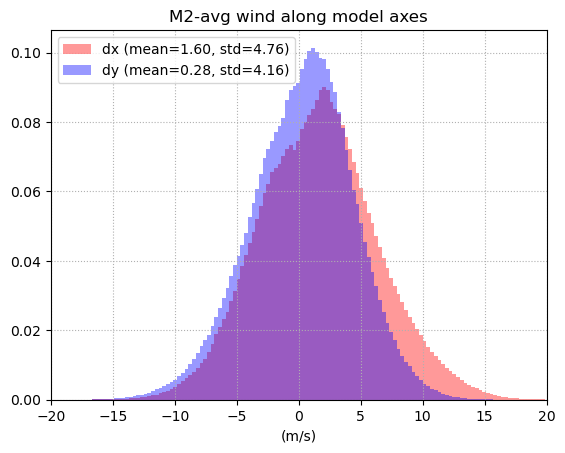

In [32]:
%%time
plt.hist(u10.values.flatten(), bins=np.arange(-20,20.3,0.3), alpha=0.4, density=True, color='red', label=f'dx (mean={np.mean(u10.values):.2f}, std={np.std(u10.values):.2f})');
plt.hist(v10.values.flatten(), bins=np.arange(-20,20.3,0.3), alpha=0.4, density=True, color='blue', label=f'dy (mean={np.mean(v10.values):.2f}, std={np.std(v10.values):.2f})');
plt.xlim(-20,20);plt.legend(); plt.grid(ls=":");
plt.title("M2-avg wind along model axes");plt.xlabel("(m/s)");

CPU times: user 1min 35s, sys: 7.55 s, total: 1min 42s
Wall time: 1min 43s


Text(0.5, 0, '(m/s)')

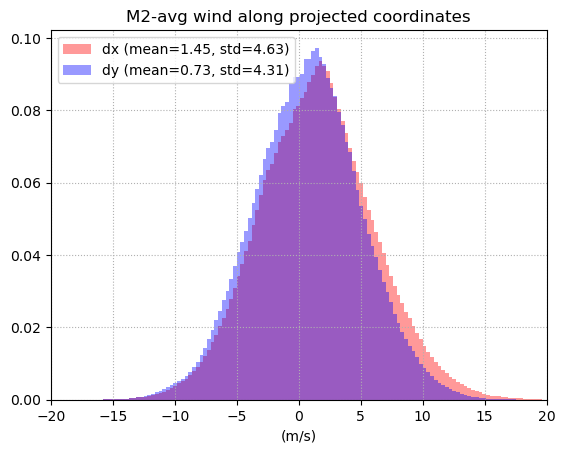

In [34]:
%%time
u10p,v10p=vel_from_local_coords_to_projection(u10,v10) #projection coords
plt.hist(u10p.values.flatten(), bins=np.arange(-20,20.3,0.3), alpha=0.4, density=True, color='red', label=f'dx (mean={np.mean(u10p.values):.2f}, std={np.std(u10p.values):.2f})');
plt.hist(v10p.values.flatten(), bins=np.arange(-20,20.3,0.3), alpha=0.4, density=True, color='blue', label=f'dy (mean={np.mean(v10p.values):.2f}, std={np.std(v10p.values):.2f})');
plt.xlim(-20,20);plt.legend(); plt.grid(ls=":");
plt.title("M2-avg wind along projected coordinates");plt.xlabel("(m/s)");

In [40]:
#check both coordinates are consistent-----

#total distance (using mean dx,dy)
print((1.6**2+0.28**2)**.5,(1.45**2+0.73**2)**.5)
print((4.76**2+4.16**2)**.5,(4.63**2+4.31**2)**.5)

1.6243152403397563 1.6233915116200404
6.32164535544347 6.325582977085985


In [24]:
#check standarized or normalized histograms for model coords----

In [14]:
a=u10.values.flatten(); b=v10.values.flatten();
a_mean=np.nanmean(a); a_std=np.nanstd(a); 
b_mean=np.nanmean(b); b_std=np.nanstd(b); 

CPU times: user 1min 45s, sys: 8.34 s, total: 1min 54s
Wall time: 1min 54s


Text(0.5, 0, 'standarized (3std)')

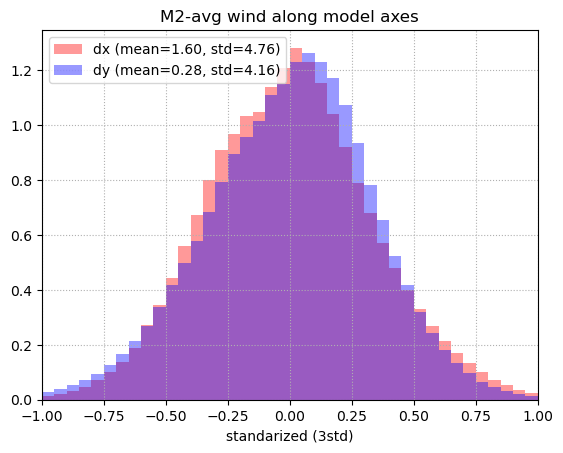

In [12]:
%%time
plt.hist((a-a_mean)/(3*a_std), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red', label=f'u10');
plt.hist((b-b_mean)/(3*b_std), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='blue', label=f'v10');
plt.xlim(-1,1);plt.legend(); plt.grid(ls=":");
plt.title("M2-avg wind along model axes");plt.xlabel("standarized (3std)");

CPU times: user 1min 29s, sys: 2.24 s, total: 1min 31s
Wall time: 1min 32s


Text(0.5, 0, 'standarized (5std)')

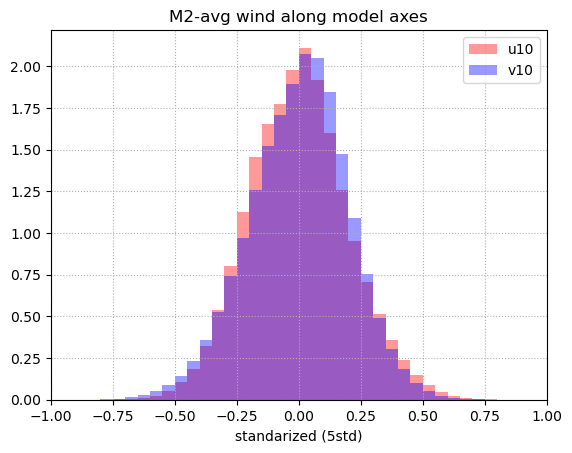

In [15]:
%%time
#check standarized or normalized histograms for model coords----
plt.hist((a-a_mean)/(5*a_std), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red', label=f'u10');
plt.hist((b-b_mean)/(5*b_std), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='blue', label=f'v10');
plt.xlim(-1,1);plt.legend(); plt.grid(ls=":");
plt.title("M2-avg wind along model axes");plt.xlabel("standarized (5std)");

CPU times: user 1min 28s, sys: 1.63 s, total: 1min 30s
Wall time: 1min 30s


Text(0.5, 0, 'standarized (4std)')

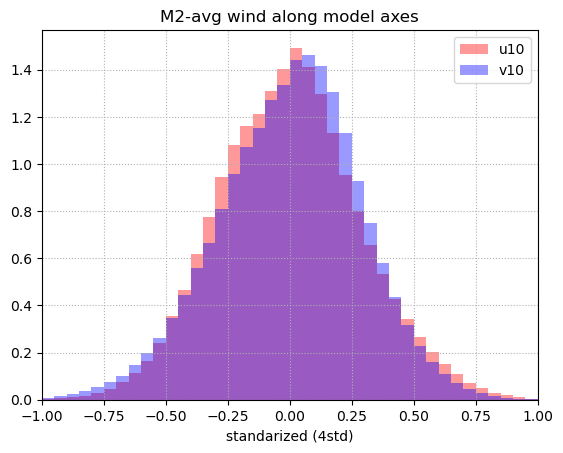

In [23]:
%%time
#check standarized or normalized histograms for model coords----
plt.hist((a-a_mean)/(3.5*a_std), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red', label=f'u10');
plt.hist((b-b_mean)/(3.5*b_std), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='blue', label=f'v10');
plt.xlim(-1,1);plt.legend(); plt.grid(ls=":");
plt.title("M2-avg wind along model axes");plt.xlabel("standarized (3.5std)");

In [17]:
#using min-max-scalar
a0=(a-np.nanmin(a))/(np.nanmax(a)-np.nanmin(a));a0=(a0-np.nanmean(a0))
b0=(b-np.nanmin(b))/(np.nanmax(b)-np.nanmin(b));b0=(b0-np.nanmean(b0))

CPU times: user 1min 27s, sys: 1.48 s, total: 1min 29s
Wall time: 1min 29s


Text(0.5, 0, '(min-max-scalar - its_mean)*1.5')

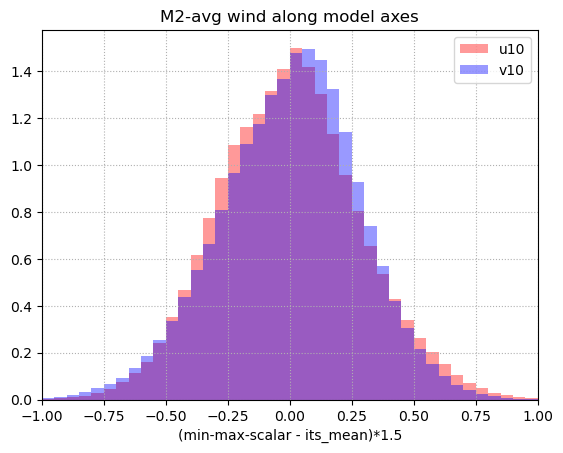

In [22]:
%%time
#So, with (minmax_scalar - its mean)*1.5 is similar than standarization with 5
plt.hist(a0*2.5, bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red', label=f'u10');
plt.hist(b0*2.5, bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='blue', label=f'v10');
plt.xlim(-1,1); plt.legend(); plt.grid(ls=":")
plt.title("M2-avg wind along model axes");plt.xlabel("(min-max-scalar - its_mean)*2.5");